In [12]:
import tqdm
import warnings
import multiprocessing
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
def check_feasibility(L, a, b):
    x = cp.Variable(len(a))
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(cp.Maximize(0), constraints)
    problem.solve()    
    return problem.status in {"optimal", "feasible"}


def solve(L, a, b, metric):

    x = cp.Variable(len(a))

    if metric == "sw":
        objective = cp.Maximize(cp.sum(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
    elif (metric == "pf") or (metric == 1):
        objective = cp.Maximize(cp.sum(cp.log(x) + cp.log(cp.multiply(-0.5*a**2, x) + b - L)))
    elif metric == "mm":
        objective = cp.Maximize(cp.min(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
    else:
        y = -0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)
        objective = cp.Maximize(cp.sum(cp.power(y, 1 - metric))/(1 - metric))
               
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver="ECOS", abstol=1e-6)

    surplus = np.sum(-0.5*a*x.value**2 + (b - L)*x.value)
    
    return problem.value, x.value, surplus


def solve_wrapper(params):
    
    L = params["L"]
    seed = params["seed"]
    n_users = params["n_users"]
    
    np.random.seed(seed)
    
    a1 = np.ones(n_users)
    a2 = np.ones(n_users)

    b1 = (a1 + 1)*L + 1*np.random.rand(n_users) + 1
    b2 = (a2 + 1)*L + 1*np.random.rand(n_users) + 5

    a = np.append(a1, a2)
    b = np.append(b1, b2)
    
    try:
        warnings.simplefilter("error")
        assert check_feasibility(L, a, b), "infeasible"
        sw_val, sw_sol, sw_surplus = solve(L, a, b, "sw")
        pf_val, pf_sol, pf_surplus = solve(L, a, b, "pf")
        mm_val, mm_sol, mm_surplus = solve(L, a, b, "mm")
        message = "success"

    except (Warning, cp.SolverError) as e:
        sw_val, sw_sol, sw_surplus = np.nan, np.full(n_users, np.nan), np.nan
        pf_val, pf_sol, pf_surplus = np.nan, np.full(n_users, np.nan), np.nan
        mm_val, mm_sol, mm_surplus = np.nan, np.full(n_users, np.nan), np.nan
        message = str(e)
        
    return dict(
        n_users=2*n_users, seed=seed, message=message,
        sw_val=sw_val, sw_sol=sw_sol, sw_surplus=sw_surplus,
        pf_val=pf_val, pf_sol=pf_sol, pf_surplus=pf_surplus,
        mm_val=mm_val, mm_sol=mm_sol, mm_surplus=mm_surplus,
    )

In [3]:
params_list = [
    dict(L=L, n_users=n_users, seed=seed)
    for L in [1] for n_users in 2**np.arange(0, 10) for seed in range(100)
]

len(params_list)

1000

In [4]:
%%time

pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
results = pool.map(solve_wrapper, params_list)
pool.close()

CPU times: user 159 ms, sys: 363 ms, total: 523 ms
Wall time: 1.4 s


In [5]:
df = pd.DataFrame(results)

In [6]:
df

,n_users,seed,message,sw_val,sw_sol,sw_surplus,pf_val,pf_sol,pf_surplus,mm_val,mm_sol,mm_surplus
0,2,0,success,6.215189,"[2.611698435870821e-09, 0.9999999973803531]",6.215189,1.313750,"[0.4826156795113934, 0.5173843152804212]",4.454129,1.634099,"[0.7520797637866197, 0.24792023622151838]",3.268198
1,2,1,success,6.220324,"[1.9231920262121464e-09, 0.9999999980685469]",6.220324,1.255746,"[0.4809857633634039, 0.5190142193629651]",4.400136,1.555446,"[0.7644168072951183, 0.23558319270313335]",3.110891
2,2,2,success,5.525926,"[3.7074422442739833e-09, 0.9999999962864087]",5.525926,1.150728,"[0.48238284323031044, 0.5176171532609743]",4.043895,1.529769,"[0.7405500712414983, 0.25944992875962036]",3.059538
3,2,3,success,6.208148,"[2.640603555458074e-09, 0.9999999973516274]",6.208148,1.313519,"[0.482649177556825, 0.5173508069061332]",4.451305,1.634886,"[0.7516876813255388, 0.2483123186847563]",3.269772
4,2,4,success,6.047232,"[4.401889423450276e-09, 0.9999999955918254]",6.047232,1.454036,"[0.4869958225296417, 0.5130041644555918]",4.553519,1.855099,"[0.7102473685384391, 0.28975263146052066]",3.710199
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1024,95,success,6.950797,"[-5.281240084258411e-13, -5.406223345582171e-1...",6.950797,-5678.722625,"[0.0009764826235225169, 0.0009764788974726747,...",4.481509,0.003474,"[0.0015591656707279124, 0.001586312750295916, ...",3.557235
996,1024,96,success,6.959995,"[-3.031258939822578e-12, -1.5887527538981428e-...",6.959995,-5673.641326,"[0.0009764822855859858, 0.0009765357728625126,...",4.504705,0.003491,"[0.0015767528129370886, 0.0012000317299706116,...",3.574552
997,1024,97,success,6.957377,"[-3.303210463979206e-12, -2.694961327616179e-1...",6.957377,-5670.942191,"[0.0009765257363287053, 0.0009765332214466972,...",4.509321,0.003506,"[0.0012361099159239072, 0.0011806225370180317,...",3.590160
998,1024,98,success,6.956891,"[-1.2339256047164797e-12, -1.458568989702479e-...",6.956891,-5676.144107,"[0.0009765329805959309, 0.0009765204435295932,...",4.496382,0.003480,"[0.0012741387284583134, 0.0013561136003480468,...",3.564016


In [7]:
# calculate price of fairness (pof)
df = pd.DataFrame(results).dropna()
df["pf_pof"] = (df.sw_surplus - df.pf_surplus) / df.sw_surplus
df["mm_pof"] = (df.sw_surplus - df.mm_surplus) / df.sw_surplus
df["diff_pof"] = df["mm_pof"] - df["pf_pof"]
df.loc[df.diff_pof<0, "diff_pof"] = np.nan


# aggregate
df_mean = df.groupby("n_users")[["pf_pof", "mm_pof", "diff_pof"]].mean().reset_index()
df_05 = df.groupby("n_users")[["pf_pof", "mm_pof", "diff_pof"]].quantile(0.05).reset_index()
df_95 = df.groupby("n_users")[["pf_pof", "mm_pof", "diff_pof"]].quantile(0.95).reset_index()

In [8]:
df.n_users.value_counts().sort_index()

2       100
4       100
8       100
16      100
32      100
64      100
128     100
256     100
512     100
1024    100
Name: n_users, dtype: int64

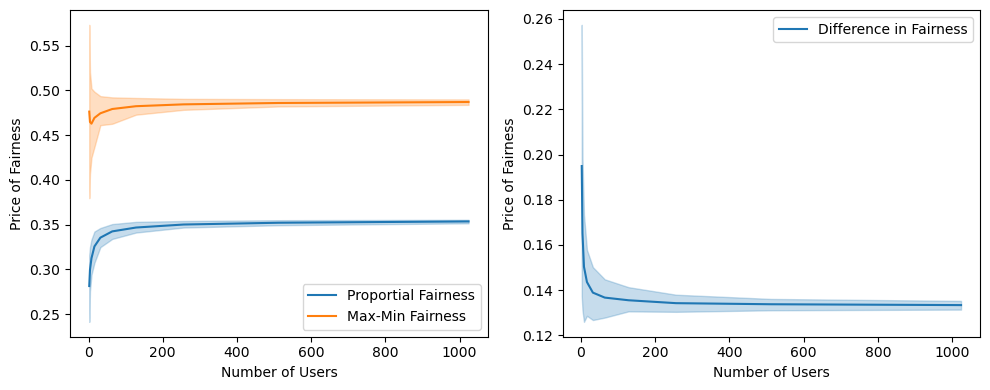

In [9]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(df_mean.n_users, df_mean.pf_pof, label="Proportial Fairness")
plt.plot(df_mean.n_users, df_mean.mm_pof, label="Max-Min Fairness")
plt.fill_between(df_mean.n_users, df_05.pf_pof, df_95.pf_pof, color="C0", alpha=0.25)
plt.fill_between(df_mean.n_users, df_05.mm_pof, df_95.mm_pof, color="C1", alpha=0.25)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.legend(loc=4)

plt.subplot(1, 2, 2)
plt.plot(df_mean.n_users, df_mean.diff_pof, label="Difference in Fairness")
plt.fill_between(df_mean.n_users, df_05.diff_pof, df_95.diff_pof, color="C0", alpha=0.25)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.legend()

plt.tight_layout()
plt.show()

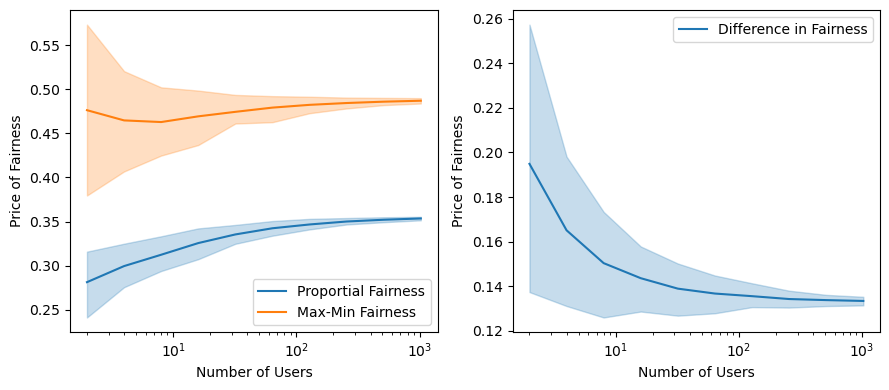

In [10]:
plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.semilogx(df_mean.n_users, df_mean.pf_pof, label="Proportial Fairness")
plt.semilogx(df_mean.n_users, df_mean.mm_pof, label="Max-Min Fairness")
plt.fill_between(df_mean.n_users, df_05.pf_pof, df_95.pf_pof, color="C0", alpha=0.25)
plt.fill_between(df_mean.n_users, df_05.mm_pof, df_95.mm_pof, color="C1", alpha=0.25)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.legend(loc=4)

plt.subplot(1, 2, 2)
plt.semilogx(df_mean.n_users, df_mean.diff_pof, label="Difference in Fairness")
plt.fill_between(df_mean.n_users, df_05.diff_pof, df_95.diff_pof, color="C0", alpha=0.25)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.legend()

plt.tight_layout()
plt.show()